<a href="https://colab.research.google.com/github/camdsDS/Cesar_Portfolio/blob/main/Titanic_from_Kaggle_Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Desafio Kaggle: https://www.kaggle.com/c/titanic
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #para transformar dados categóricos em numéricos
from sklearn.model_selection import train_test_split #para dividir os dados de teste em um grupo para desenvolver o modelo e outro para validar o modelo
from sklearn.linear_model import LogisticRegression #para realizar a regressão logística
from sklearn.metrics import accuracy_score #para avaliar a acurácia do modelo

In [2]:
base = pd.read_csv('train.csv')
classe = pd.read_csv('test.csv')

In [3]:
base.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Para mais informações sobre o tipo de dado apresentado em cada coluna, visite: https://www.kaggle.com/c/titanic/data
#Irei elaborar um modelo para testar a hipótese de que os dados Pclass, Sex, Age, SibSp, Parch, Fare e Embarked têm relação
#com as chances do passageiro sobreviver

In [5]:
#primeiro vamos retirar de nossa base de dados as colunas que não fazem parte de nossa hipótese
base = base.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

In [6]:
#Agora vamos tratar os dados. Começaremos procurando por dados missing
base.isna().sum().to_frame().rename(columns={0:'missing'})

,missing
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

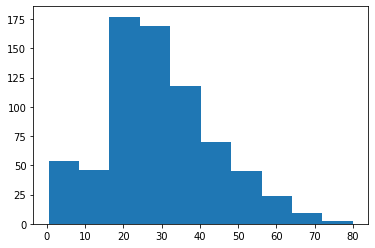

In [7]:
#Vamos dar uma olhada nos dados do tipo Age
plt.hist(base.Age)

In [8]:
#Para resolver o problema, vou substituir os valores NaN pelo valor moda dos atributos Age
base['Age'].value_counts() #daqui sabemos que a idade de 24 anos é a moda

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [9]:
 #O dado missing de Embarked também irei substituir pelo valor da moda
base['Embarked'].value_counts() #daqui sabemos que o Embarked S é a moda

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
#substituindo os valores missing por 24.00 no age e por S no Embarked
valores = {'Age': 24.00, 'Embarked': 'S'}
base = base.fillna(value=valores)

In [11]:
#procurando por valores inconsistentes
i1 = base.loc[base.Age > 100] #não retornou nenhum valor
i2 = base.loc[base.Fare <= 0] #retornou 15 registros iguais a zero

In [12]:
# Vou determinar que na minha base só vão entrar registros com Fare > 0,
#pois registros do tipo Fare == 0 não reprentam tarifas muito baratas, mas
#casos excepcionais em que o passageiro embarcou sem precisa pagar o fare)
base = base[base.Fare > 0]

In [13]:
# montando dataframes conforme o tipo de dado. Montaremos 3 DF: categoricas (que precisará de get.dummys), ordinais e contínuas
df_categoricas = base[['Sex', 'Embarked']]

In [14]:
#dummy das categoricas
df_categoricas = pd.get_dummies(data=df_categoricas, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=True, dtype=None)

In [15]:
#df dos ordinais
df_ordinais = base[['SibSp', 'Parch']]

In [16]:
#df dos contínuas
df_continuas = base[['Age', 'Fare']]

In [17]:
#com os dfs separados e tratados, vamos juntá-los agora. Primeiro juntamos 2
pd.merge(df_categoricas, df_ordinais, how='left', left_index=True, right_index=True)

,Sex_male,Embarked_Q,Embarked_S,SibSp,Parch
0,1,0,1,1,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,0
4,1,0,1,0,0
...,...,...,...,...,...
886,1,0,1,0,0
887,0,0,1,0,0
888,0,0,1,1,2
889,1,0,0,0,0


In [18]:
#depois juntamos o juntado com o que faltou
abt = pd.merge(pd.merge(df_categoricas, df_ordinais, how='left', left_index=True, right_index=True), df_continuas, how='left', left_index=True, right_index=True)

In [19]:
#agora vamos normalizar os dados
#passo 1
scaler = MinMaxScaler()
scaler.fit(abt)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [20]:
#agora vamos normalizar os dados
#passo 2
abt_n = pd.DataFrame(scaler.transform(abt), columns=abt.columns)

In [21]:
#agora copiamos o df para uma variável explicativas
explicativas = abt_n.copy()
respostas = base['Survived']

In [22]:
#Desenvolvimento e validação

In [23]:
#Dividindo minha base de teste em um grupo de desenvolvimento e outro de validação (70% e 30%, respectivamente)
x_desenv, x_valid, y_desenv, y_valid = train_test_split(explicativas, respostas, test_size = 0.3, random_state=40)

In [24]:
#rodando o modelo com os dados do grupo de desenvolvimento
log = LogisticRegression()
log.fit(x_desenv, y_desenv)
desenvPredict = log.predict(x_desenv)
desenvProba = log.predict_proba(x_desenv)

In [25]:
#Validando com o grupo de validação
desenvPredict2 = log.predict(x_valid)
desenvProba2 = log.predict_proba(x_valid)
accuracy_score(y_valid, desenvPredict2)

0.7946768060836502

In [26]:
#agora precisamos usar nosso modelo para fazer a previsão usando o csv classe.
#Para isso, precisamos tratar os dados de classe assim como tratamos os dados de base

In [27]:
#Vamos apagar as mesmas colunas que apagamos em base
classe = classe.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

In [28]:
#procurar por dados do tipo missing
classe.isna().sum().to_frame().rename(columns={0:'missing'}) #faltam 86 dados do tipo Age e 1 do tipo Fare

,missing
Pclass,0
Sex,0
Age,86
SibSp,0
Parch,0
Fare,1
Embarked,0


24.0    17
21.0    17
22.0    16
30.0    15
18.0    13
        ..
7.0      1
60.5     1
26.5     1
76.0     1
34.5     1
Name: Age, Length: 79, dtype: int64

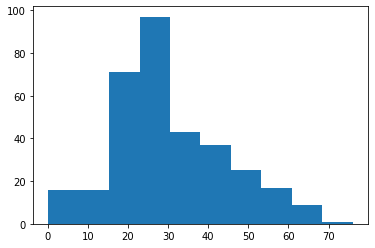

In [29]:
plt.hist(classe.Age)
classe['Age'].value_counts()

7.7500     21
26.0000    19
8.0500     17
13.0000    17
7.8958     11
           ..
9.3250      1
14.4583     1
15.0333     1
25.4667     1
21.0750     1
Name: Fare, Length: 169, dtype: int64

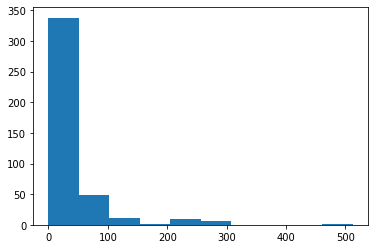

In [30]:
plt.hist(classe.Fare)
classe['Fare'].value_counts()

In [31]:
#Substituindo os valores missing
valores2 = {'Fare': 7.7500, 'Age':24.0}
classe = classe.fillna(value=valores2)

In [32]:
#Separação e junção dos df
df_categoricasC = classe[['Sex', 'Embarked']]
df_categoricasC = pd.get_dummies(data=df_categoricasC, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=True, dtype=None)
df_ordinaisC = classe[['SibSp', 'Parch']]
df_continuasC = classe[['Age', 'Fare']]

In [33]:
pd.merge(df_categoricasC, df_ordinaisC, how='left', left_index=True, right_index=True)

,Sex_male,Embarked_Q,Embarked_S,SibSp,Parch
0,1,1,0,0,0
1,0,0,1,1,0
2,1,1,0,0,0
3,1,0,1,0,0
4,0,0,1,1,1
...,...,...,...,...,...
413,1,0,1,0,0
414,0,0,0,0,0
415,1,0,1,0,0
416,1,0,1,0,0


In [34]:
abtC = pd.merge(pd.merge(df_categoricasC, df_ordinaisC, how='left', left_index=True, right_index=True), df_continuasC, how='left', left_index=True, right_index=True)

In [35]:
#normalização
scaler = MinMaxScaler()
scaler.fit(abtC)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [36]:
abt_nC = pd.DataFrame(scaler.transform(abtC), columns=abt.columns)

In [37]:
#Vamos chamar de desafio o df com os dados que serão o input de nossa previsão
desafio = abt_nC.copy()

In [38]:
#rodando o modelo com o desafio

In [39]:
desafioP = log.predict(desafio)

In [40]:
#Como eu quero um csv com o PassengerId e Survived, vou abrir novamente o arquivo csv test (que tem o PassengerId) e depois vou colocar uma coluna resposta (que será a coluna Survived)
classefinal = pd.read_csv('test.csv')

In [41]:
#Inserindo coluna Survived
classefinal['Survived'] = desafioP

In [42]:
#Deixando meu DataFrame apenas com os dados solicitados: PassengerId e Survived
classefinal = classefinal[['PassengerId', 'Survived']]

In [43]:
#Gerando arquivo resposta do Desafio
classefinal.to_csv('DesafioTitanic.csv', index = False, sep = ',')